In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install tensorflow-io --no-deps

In [3]:
!pip install --upgrade tensorflow-io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 48.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 39.0 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.31.0
    Uninstalling tensorflow-io-gcs-filesystem-0.31.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.31.0
  Attempting uninstall: tensorflow-io
    Found existing installation: tensorflow-io 0.31.0
    Uninstalling tensorflow-io-0.31.0:
      Successfully uninstalled tensorflow-io-0.31.0


In [4]:
import tensorflow as tf
import os
import random
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [9]:
base_dir = '/kaggle/input/foodimage'
data_dir = '/kaggle/input/foodimage/foodimage'

In [10]:
filepaths=[]
labels=[]
allowed_extensions = ['.png', '.jpeg', '.jpg'] 
classlist=os.listdir(data_dir)
for img_class in classlist:
    classpath=os.path.join(data_dir,img_class)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(img_class)                   
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths    labels
0  /kaggle/input/foodimage/foodimage/takoyaki/843...  takoyaki
1  /kaggle/input/foodimage/foodimage/takoyaki/155...  takoyaki
2  /kaggle/input/foodimage/foodimage/takoyaki/216...  takoyaki
3  /kaggle/input/foodimage/foodimage/takoyaki/581...  takoyaki
4  /kaggle/input/foodimage/foodimage/takoyaki/362...  takoyaki
takoyaki         1000
bibimbap         1000
donuts           1000
ramen            1000
hamburger        1000
waffles          1000
ice_cream        1000
chicken_wings    1000
sushi            1000
pizza            1000
hot_dog          1000
pancakes         1000
fried_rice       1000
french_fries     1000
rice              621
Name: labels, dtype: int64


In [11]:
train_dir = '/kaggle/working/train'
os.makedirs(train_dir, exist_ok=True)

test_dir = '/kaggle/working/test'
os.makedirs(test_dir, exist_ok=True)

validation_dir = '/kaggle/working/validation'
os.makedirs(validation_dir, exist_ok=True)

In [12]:
train_ratio = .8
test_ratio = .1
validation_ratio = 1 - (train_ratio + test_ratio)

In [13]:
train_data, validation_data = train_test_split(df, test_size=test_ratio, random_state=123)
train_data, test_data = train_test_split(train_data, test_size=validation_ratio, random_state=123)

In [14]:
# Memindahkan file gambar ke direktori yang sesuai
import shutil

# Memindahkan file gambar ke direktori train
for index, row in train_data.iterrows():
    file_path = row['filepaths']
    label = row['labels']
    destination_dir = os.path.join(train_dir, label)
    os.makedirs(destination_dir, exist_ok=True)
    shutil.copy(file_path, destination_dir)

# Memindahkan file gambar ke direktori test
for index, row in test_data.iterrows():
    file_path = row['filepaths']
    label = row['labels']
    destination_dir = os.path.join(test_dir, label)
    os.makedirs(destination_dir, exist_ok=True)
    shutil.copy(file_path, destination_dir)

# Memindahkan file gambar ke direktori validation
for index, row in validation_data.iterrows():
    file_path = row['filepaths']
    label = row['labels']
    destination_dir = os.path.join(validation_dir, label)
    os.makedirs(destination_dir, exist_ok=True)
    shutil.copy(file_path, destination_dir)

In [15]:
print ('train_df length: ', len(train_data), '  test_df length: ', len(test_data), '  validation_df length: ', len(validation_data))

train_df length:  11842   test_df length:  1316   validation_df length:  1463


In [16]:
image_size = (224, 224)
batch_size = 20

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

Found 11842 images belonging to 15 classes.
Found 1316 images belonging to 15 classes.
Found 1462 images belonging to 15 classes.


In [17]:
def show_image_samples(gen):
    classes = train_generator.class_indices
    class_names = list(classes.keys())

    images, labels = next(gen)  # Get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length = len(labels)
    if length < 25:  # Show a maximum of 25 images
        r = length
    else:
        r = 25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = images[i]
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = class_names[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()


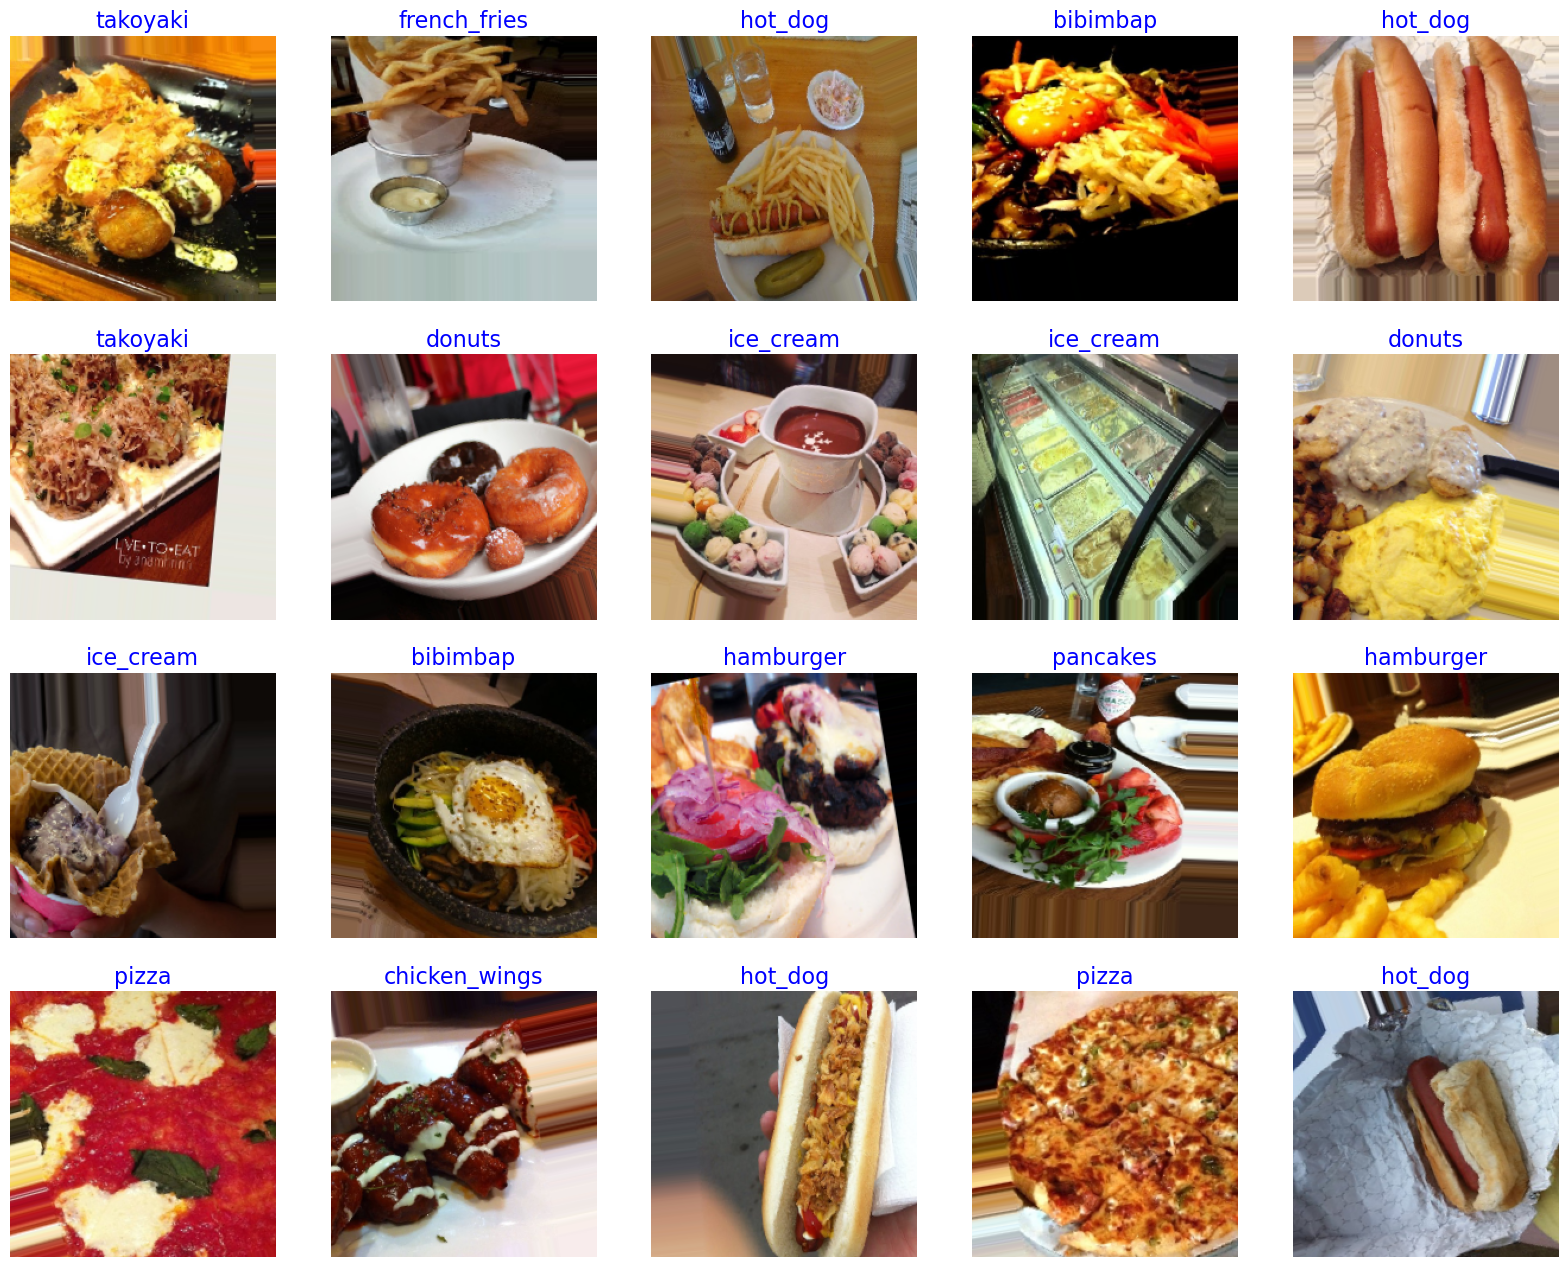

In [18]:
show_image_samples(train_generator)

In [19]:
from tensorflow.keras.layers import Dense, Dropout, Flatten

In [22]:
input_shape = (224, 224, 3)
num_classes = len(train_generator.class_indices)

def create_model(input_shape, num_classes):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

In [23]:
model = create_model(input_shape, num_classes)
model.summary()

29084464/29084464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

In [24]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
#import math
epochs=100
verbose = 1

#total_samples = len(train_generator)*train_generator.batch_size
#steps_per_epoch = math.ceil(total_samples/batch_size)

# Callback untuk memberhentikan pelatihan jika val_accuracy tidak meningkat dalam 8 epoch
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, mode='max', verbose=1)

# Callback untuk menyimpan model terbaik berdasarkan val_accuracy
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

history = model.fit(
    train_generator,
    epochs=epochs,
    verbose=verbose,
    validation_data=validation_generator,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/100
593/593 [==============================] - ETA: 0s - loss: 1.9144 - accuracy: 0.4084
Epoch 1: val_accuracy improved from -inf to 0.44460, saving model to best_model.h5
593/593 [==============================] - 202s 341ms/step - loss: 1.9144 - accuracy: 0.4084 - val_loss: 2.0134 - val_accuracy: 0.4446
Epoch 2/100
593/593 [==============================] - ETA: 0s - loss: 1.6407 - accuracy: 0.4962
Epoch 2: val_accuracy improved from 0.44460 to 0.51163, saving model to best_model.h5
593/593 [==============================] - 202s 340ms/step - loss: 1.6407 - accuracy: 0.4962 - val_loss: 1.7058 - val_accuracy: 0.5116
Epoch 3/100
593/593 [==============================] - ETA: 0s - loss: 1.4783 - accuracy: 0.5632
Epoch 3: val_accuracy did not improve from 0.51163
593/593 [==============================] - 199s 335ms/step - loss: 1.4783 - accuracy: 0.5632 - val_loss: 1.8861 - val_accuracy: 0.4884
Epoch 4/100
593/593 [==============================] - ETA: 0s - loss: 1.3081 - accu

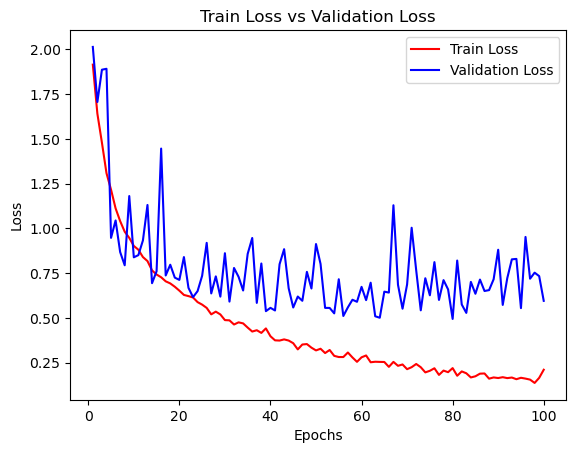

In [27]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot train loss dan validation loss
plt.plot(epochs, train_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Train Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

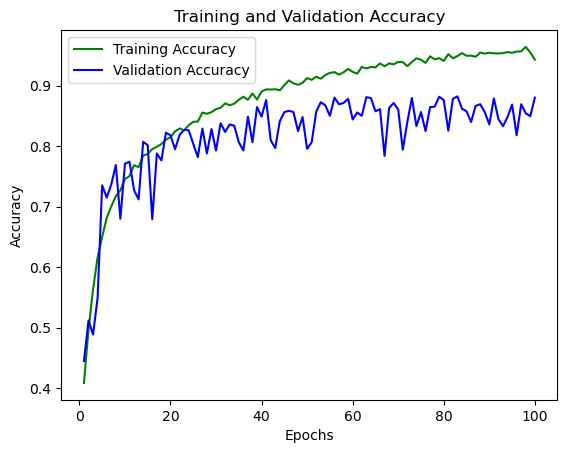

In [28]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
# Evaluasi model
test_loss, test_acc = model.evaluate(test_generator)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

66/66 [==============================] - 6s 91ms/step - loss: 0.6285 - accuracy: 0.8655
Test Loss: 0.628456175327301
Test Accuracy: 0.8655015230178833


In [30]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

best_model = tf.keras.models.load_model('best_model.h5')

def predict_image(file, class_names):
    img = tf.keras.preprocessing.image.load_img(file, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = best_model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_probability = np.max(prediction)

    probabilities = [round(float(p), 3) for p in prediction[0]]

    for i in range(len(class_names)):
        print("Prediction probability for {0}: {1}%".format(class_names[i], probabilities[i] * 100))

    return class_names[predicted_class_index], predicted_probability

# File path
uploaded_file = '/kaggle/input/testupload/download (3).jpeg'

# Convert dict_keys to list
class_names_list = list(train_generator.class_indices.keys())

# Predict image class
predicted_class, predicted_probability = predict_image(uploaded_file, class_names_list)

print("Prediction:", predicted_class)
print("Probability:", predicted_probability)


1/1 [==============================] - 3s 3s/step
Prediction probability for bibimbap: 0.0%
Prediction probability for chicken_wings: 0.0%
Prediction probability for donuts: 0.0%
Prediction probability for french_fries: 0.0%
Prediction probability for fried_rice: 0.0%
Prediction probability for hamburger: 0.0%
Prediction probability for hot_dog: 0.0%
Prediction probability for ice_cream: 0.0%
Prediction probability for pancakes: 0.0%
Prediction probability for pizza: 0.0%
Prediction probability for ramen: 0.0%
Prediction probability for rice: 0.0%
Prediction probability for sushi: 0.0%
Prediction probability for takoyaki: 0.0%
Prediction probability for waffles: 100.0%
Prediction: waffles
Probability: 1.0


In [31]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

highest_model = load_model('best_model.h5')
# Mengumpulkan prediksi model untuk data uji
y_pred = highest_model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)

# Mengambil label sebenarnya dari generator
y_true_labels = test_generator.classes

# Mendapatkan nama kelas dari generator
class_names = list(test_generator.class_indices.keys())

# Membuat classification report
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names)

# Menampilkan classification report
print(report)

66/66 [==============================] - 6s 67ms/step
               precision    recall  f1-score   support

     bibimbap       0.08      0.07      0.08       111
chicken_wings       0.08      0.10      0.09        93
       donuts       0.10      0.08      0.09        86
 french_fries       0.06      0.06      0.06        93
   fried_rice       0.10      0.08      0.09        83
    hamburger       0.12      0.11      0.11        84
      hot_dog       0.01      0.01      0.01        82
    ice_cream       0.11      0.14      0.12       100
     pancakes       0.06      0.07      0.07        86
        pizza       0.05      0.05      0.05        88
        ramen       0.09      0.09      0.09       102
         rice       0.06      0.06      0.06        49
        sushi       0.05      0.04      0.04        81
     takoyaki       0.04      0.04      0.04        76
      waffles       0.07      0.09      0.08       102

     accuracy                           0.07      1316
    macro